# ch07/simple_convnet.py

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# ch07/train_convnet.py

Adamの場合

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.298962999502043
=== epoch:1, train acc:0.336, test acc:0.293 ===
train loss:2.295017416426505
train loss:2.2849501189216523
train loss:2.2737098432313454
train loss:2.264722402462739
train loss:2.235677693684026
train loss:2.213622949035235
train loss:2.176391732187889
train loss:2.141220067494206
train loss:2.087033369104214
train loss:1.981054929889838
train loss:1.986546925697906
train loss:1.869249375782143
train loss:1.8193646451996641
train loss:1.6400125730071762
train loss:1.6992014484933722
train loss:1.5148098489667499
train loss:1.3897010958841798
train loss:1.4054666219902359
train loss:1.318604956353257
train loss:1.3224999148483858
train loss:1.2668763968755563
train loss:1.0645006595488

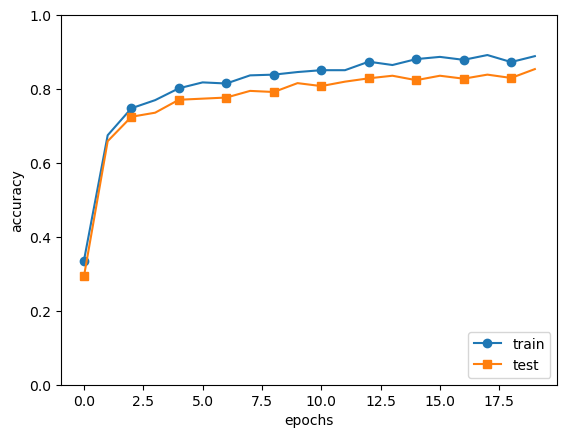

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("../ch07/params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


RMSpropの場合

train loss:12.391746413023084
=== epoch:1, train acc:0.132, test acc:0.124 ===
train loss:5.308757339174512
train loss:2.3156748193043284
train loss:2.3423081832848727
train loss:2.3288908856883825
train loss:2.2898740849261774
train loss:2.3171615969403767
train loss:2.3032091520463354
train loss:2.3001244647849823
train loss:2.278657488651593
train loss:2.2430216032833714
train loss:2.1985970487792406
train loss:2.149628444760588
train loss:1.9904520724790387
train loss:1.917277362626429
train loss:2.0013667173141996
train loss:1.627848794359742
train loss:1.5397055735212657
train loss:1.5058918052399326
train loss:1.3522204838220975
train loss:1.4598261043136938
train loss:1.309871184544778
train loss:1.2202930185612002
train loss:1.2658339245212826
train loss:1.0936872986942623
train loss:1.268158701763252
train loss:1.1727941132805848
train loss:1.0052549980096919
train loss:1.0640444365470552
train loss:1.083679033505445
train loss:1.0673667830020415
train loss:0.957456771915971


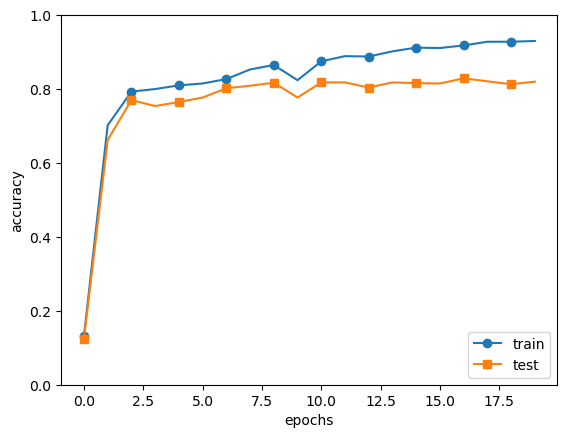

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='RMSprop', optimizer_param={'lr': 0.01},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("../ch07/params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


# データを可視化する

(60000, 1, 28, 28)
(60000,)
picture num:0 to 9
Label:[9 0 0 3 0 2 7 2 5 5]


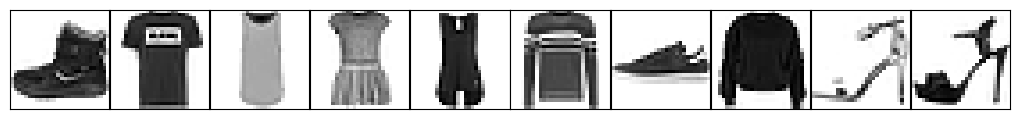

picture num:10 to 19
Label:[0 9 5 5 7 9 1 0 6 4]


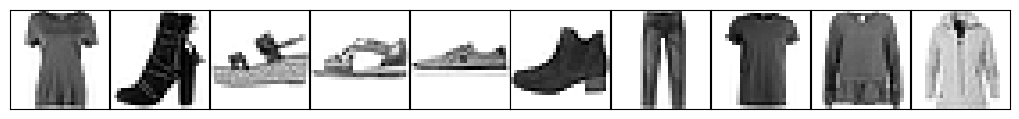

picture num:20 to 29
Label:[3 1 4 8 4 3 0 2 4 4]


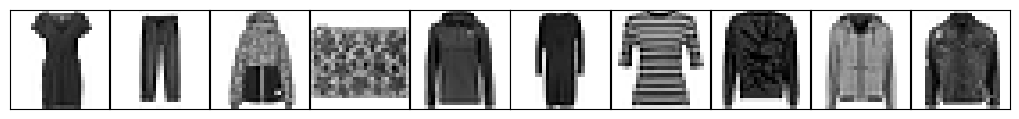

picture num:30 to 39
Label:[5 3 6 6 0 8 5 2 1 6]


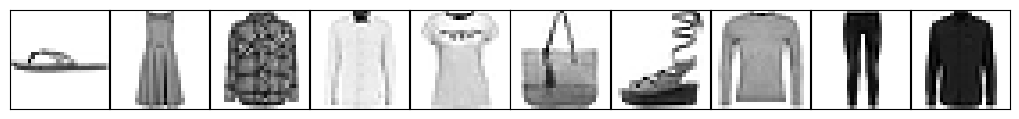

picture num:40 to 49
Label:[6 7 9 5 9 2 7 3 0 3]


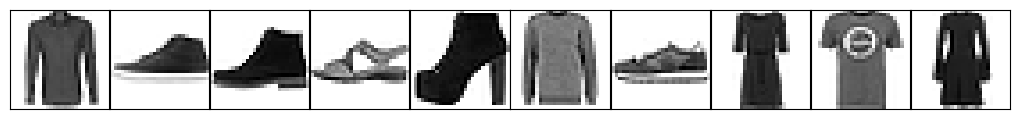

picture num:50 to 59
Label:[3 3 7 2 2 6 6 8 3 3]


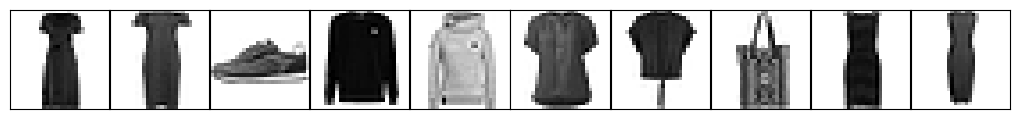

picture num:60 to 69
Label:[5 0 5 5 0 2 0 0 4 1]


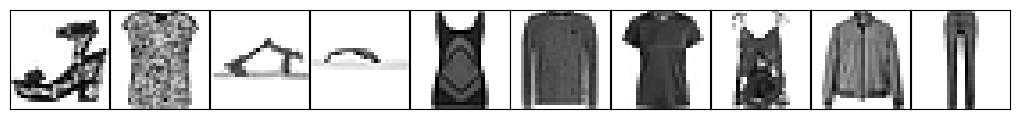

picture num:70 to 79
Label:[3 1 6 3 1 4 4 6 1 9]


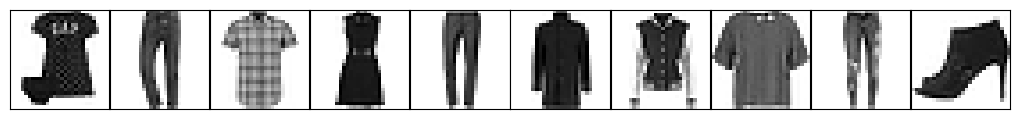

picture num:80 to 89
Label:[1 3 5 7 9 7 1 7 9 9]


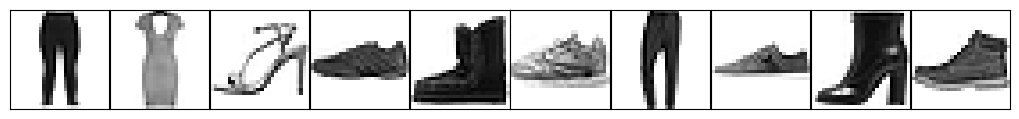

picture num:90 to 99
Label:[9 3 2 9 3 6 4 1 1 8]


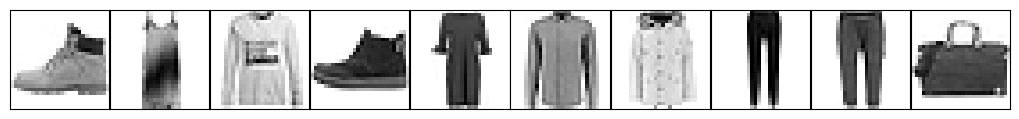

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist
import matplotlib.pylab as plt

# 0から999まで出力させる
start_num = 0   #開始番号
col_num = 10    #1行の画像数
row_num = 10   #表示列数
current_view = 1

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False, normalize=False)
print(x_train.shape)
print(t_train.shape)

i = 0
for i  in range(row_num):
    print("picture num:" + str(start_num) + " to " + str(start_num+col_num-1))
    print("Label:" + str(t_train[start_num:start_num+col_num]))
    # 画像
    j = 0
    current_view = 1
    fig = plt.figure(figsize=(10, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for j in range(col_num):
        ax = fig.add_subplot(1, col_num, current_view, xticks=[], yticks=[])
        img = x_train[start_num + j,:]
        ax.imshow(img[0], cmap=plt.cm.gray_r, interpolation='nearest')
        current_view += 1
        if current_view > col_num:
            plt.show()
            start_num = start_num + col_num
            break